We wanted to maintain the spirit of the project, which involves topology optimisation - so how can we change the locations of columns to get a better structure.

Then we also wanted to be a bit fancy and plot our structures next to each other to allow easier visual comparison.

In [480]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [481]:
#  This here generates a portal frame with random columns. This generates all the lists necessary to create the matrices in the assemble_model definition.

def generate_portal_frame(width, height, resolution, no_columns, UDL, wind_force):


  top_beam_node_coord = []
  btm_node_coord = []
  for i in range( resolution +1 ):
    top_beam_node_coord.append([ i*width/resolution, height])
    btm_node_coord.append([ i*width/resolution, 0])

  # combining top beam and bottom (ground) nodes in one coordinate list
  node_coord = np.array( top_beam_node_coord + btm_node_coord )    # global coordinates of each node (mm)



  # creating line elements connecting nodes. First columns then the top beam.
  nodes_el = []                       

  for i in range(no_columns):          # create column elements
    element = []
    element.append( random.randint(0 , resolution) )
    element.append( random.randint(resolution +1 , resolution*2 + 1) )
    nodes_el.append(element)

  for i in range(resolution):     # create elements for top beam of portal. These will appear after the columns in the element list
    element = [i , i + 1]
    nodes_el.append(element)

  nodes_el = np.array(nodes_el)                    # starting and ending nodes of each element (-)



  # mechanical properties of each element
  E_el = []
  I_el = []
  A_el = []

  for i in range( int(nodes_el.size /2 )):
    E_el.append( 30 )
    I_el.append( 65 )
    A_el.append( 7 )

  E_el = np.array(E_el)*10**3*6.9                  # Young's modulus of each element (MPa)
  I_el = np.array(I_el)*400000                     # Moment of intertia of each element cross section (mm^4)
  A_el = np.array(A_el)*645                        # Cross section area of each element (mm^2)



  # length and rotation of each element
  L_el =  []                          # Length of each element (mm)
  phi_el = []                         # Rotation angle with global coordinates

  for i in range( int(nodes_el.size /2 )):
    start = node_coord[ nodes_el[ i,0 ] , : ]
    end =   node_coord[ nodes_el[ i,1 ] , : ]

    length = math.sqrt( (end[0] - start[0])**2 + (end[1] - start[1])**2 )
    L_el.append(length)

    # Getting the rotation of the element
    def dot(vA, vB):
      return vA[0]*vB[0]+vA[1]*vB[1]

    def ang(start, end):
      # Get nicer vector form
      vA = [(end[0]-start[0]), (end[1]-start[1])]
      vB = [1, 0] # flat line along x
      # Get dot prod
      dot_prod = dot(vA, vB)
      # Get magnitudes
      magA = dot(vA, vA)**0.5
      magB = dot(vB, vB)**0.5
      # Get cosine value
      cos_ = dot_prod/magA/magB
      # Get angle in radians and then convert to degrees
      angle = math.acos(dot_prod/magB/magA)
      # Basically doing angle <- angle mod 360
      ang_deg = math.degrees(angle)%360
      return angle

    rotation = ang(start, end)
    phi_el.append(rotation)

  L_el = np.array(L_el)
  phi_el = np.array(phi_el)



  # Degrees of Freedom. All nodes along top cord. None along the bottom. In node_coord list, the top nodes come first, so we just need to give them 3 degrees of freedom each   
  dof = []                                   # free degrees of freedom - determined via boundary conditions
  for i in range( ( resolution + 1 ) * 3): # The top beam is free to move. The bottom (ground) is not. There are 'resolution' + 1 nodes along the top beam and each has 3 degrees of freedom.
    dof.append(i)



  # Force assembly
  # This uses each degree of freedom, hence 3 for each node. X force, Y force and moment force
  # The Force list will be 3x the length of the node_coord list
  F = []
  for i in range(int(node_coord.size /2)):
    if i < int(node_coord.size/2/2): # for the top nodes, the first half of the list
      # X force
      F.append( wind_force / (resolution + 1))
      # Y force
      F.append( -UDL * width / 1000 / (resolution + 1) )
      # moment force
      F.append(0) # this is currently ignored for simplicity's sake

    else: # for the bottom nodes, the last half of the list
      F.append(0)
      F.append(0)
      F.append(0)

  F = np.array(F)

  return (node_coord, nodes_el, E_el, I_el, A_el, L_el, phi_el, dof, F)

In [482]:
# This is the general Element matrix assembly. Originally provided by Charalampos Andriotis, teacher of the FEM Python course, but transformed into a definition to suit our needs.

def assemble_model():

  # ELEMENT MATRICES

  # Element rotation transformation matrices
  n_el = len(nodes_el)                                     
  T = np.zeros((n_el,6,6))
  def rotation_matrices():
      for i in range(n_el):
          x=phi_el[i]
          T[i,:,:] = np.array([[np.cos(x) , np.sin(x), 0,     0    ,     0    , 0],
                              [-np.sin(x), np.cos(x), 0,     0    ,     0    , 0],
                              [    0     ,     0    , 1,     0    ,     0    , 0],
                              [    0     ,     0    , 0, np.cos(x), np.sin(x), 0],
                              [    0     ,     0    , 0,-np.sin(x), np.cos(x), 0],
                              [    0     ,     0    , 0,     0    ,     0    , 1]])        
      return T


  # Element stiffness matrices in local coordinate systems
  k_el = np.zeros((n_el,6,6))
  def stifness_matrices():
      for i in range(n_el):
          E=E_el[i]
          A=A_el[i]
          I=I_el[i]
          L=L_el[i]
          k_el[i,:,:] = np.array([[E*A/L ,     0      ,    0      ,-E*A/L,       0    ,     0     ],
                                  [0     ,E*I/L**3*12 ,E*I/L**2*6 ,   0  ,-E*I/L**3*12, E*I/L**2*6],
                                  [0     ,E*I/L**2*6  ,  E*I/L*4  ,   0  ,-E*I/L**2*6 ,  E*I/L*2  ],
                                  [-E*A/L,      0     ,    0      , E*A/L,       0    ,     0     ],
                                  [0     ,-E*I/L**3*12,-E*I/L**2*6,   0  ,E*I/L**3*12 ,-E*I/L**2*6],
                                  [0     ,E*I/L**2*6 ,  E*I/L*2   ,   0  ,-E*I/L**2*6 ,   E*I/L*4 ]]) 
      return k_el



  # STRUCTURAL MATRICES

  # Stiffness assembly
  n_node = len(node_coord)
  K = np.zeros((3*n_node,3*n_node))
  def stiffness_assembly():
      for i in range(n_el):
          st = nodes_el[i,0]
          en = nodes_el[i,1]
          K_el = np.matmul(np.matmul(T[i].T,k_el[i]),T[i])
          K[st*3:st*3+3,st*3:st*3+3] += K_el[0:3,0:3]
          K[st*3:st*3+3,en*3:en*3+3] += K_el[0:3,3:6]
          K[en*3:en*3+3,st*3:st*3+3] += K_el[3:6,0:3]
          K[en*3:en*3+3,en*3:en*3+3] += K_el[3:6,3:6]      
      return K



  # SOLUTION

  # Element matrices
  T=rotation_matrices()
  k_el=stifness_matrices()

  # Stiffness Assembly
  K=stiffness_assembly()

  #Apply boundary conditions
  K_dof = K[dof]
  K_dof = K_dof[:,dof]
  F_dof = F[dof]

  # solve linear algebraic equations
  q_dof = np.linalg.solve(K_dof,F_dof)

  return q_dof

In [484]:
# scaling the deformed model to make it visible how much it has deformed

def deform_model(deformation_scale):

  def_coord = []

  for i in range(resolution +1):
    def_coord.append([ node_coord[i,0]+q_dof[i*3+0] * deformation_scale,
                      node_coord[i,1]+q_dof[i*3+1] * deformation_scale])

  def_coord = np.array(def_coord)
  def_coord = np.append(def_coord, node_coord[resolution+1:], axis=0)

  return def_coord

# Experiments begin

Below here you can adjust the numbers to generate different portal frames.

## Parameter inputs below here

This script will run x number of random portal frames with the given size.

Width and height describe the extents of the portal frame.

Resolution is how many divisions along the portal frame to create for potential column attachment points. This also gives a more detailed/smooth plotting of the portal, but does increase the calculation complexity as more nodes are created.

no_columns is how many columns will be in the generated portal frame

UDL is the Uniform Distributed Load

wind force is the horizontal wind force from left to right

In [670]:
#Portal frame specs
width = 6000        # mm
height = 2500       # mm
resolution = 10      # number of divisions along width. Higher number gives more detailed structure
no_columns = 3      # how many columns are allowed in your structure
UDL = 1000          # Uniform Distributed Load, N/m. Per length of the top beam
wind_force = 1000   # total wind force in x+ direction, Newtons

deformation_scale = 300 # how exagerated the deformation is plotted further below
# scale of 1 will show the true deformation relative to size of structure


# change the random multiplier to get different results while still using the same num_iterations
random_multiplier = 754

num_iterations = 400

## End of adjustable parameters
You shouldn't change anything below, except for running the cell plotting the final massive graph, but only if num_iterations is less than 625 or so.

Here it calculates all the generated structure and finds the best one.

In [671]:
# First we generate new lists to contain a list of lists. One for each iteration generated.  This is a way to save each iteration. This is unpacked later when plotting them again.

list_of_deformed = []
list_of_nodes_el = []
max_deformation = []

for each in range(num_iterations):
  random.seed(each * random_multiplier)
  # Assemble and analyse portal frame
  node_coord, nodes_el, E_el, I_el, A_el, L_el, phi_el, dof, F = generate_portal_frame(width, height, resolution, no_columns, UDL, wind_force)
  q_dof = assemble_model()
  # deform based on scale factor
  def_coord = deform_model(deformation_scale)

  # Add max deformation to list to track fitness performance
  max_deformation.append(max((node_coord - def_coord)[:,1]))

  list_of_deformed.append(def_coord)
  list_of_nodes_el.append(nodes_el)

# convert to numpy
list_of_deformed = np.array(list_of_deformed)
list_of_nodes_el = np.array(list_of_nodes_el)


# Results

Numerical results for the best seed and plot of the portal frame below

In [672]:
print('The best performing seed is number:          ',  max_deformation.index(min(max_deformation))  )
print('The maximum deformation for this seed is:    ', min(max_deformation) /  deformation_scale, ' mm')

The best performing seed is number:           133
The maximum deformation for this seed is:     0.08141356943378165  mm


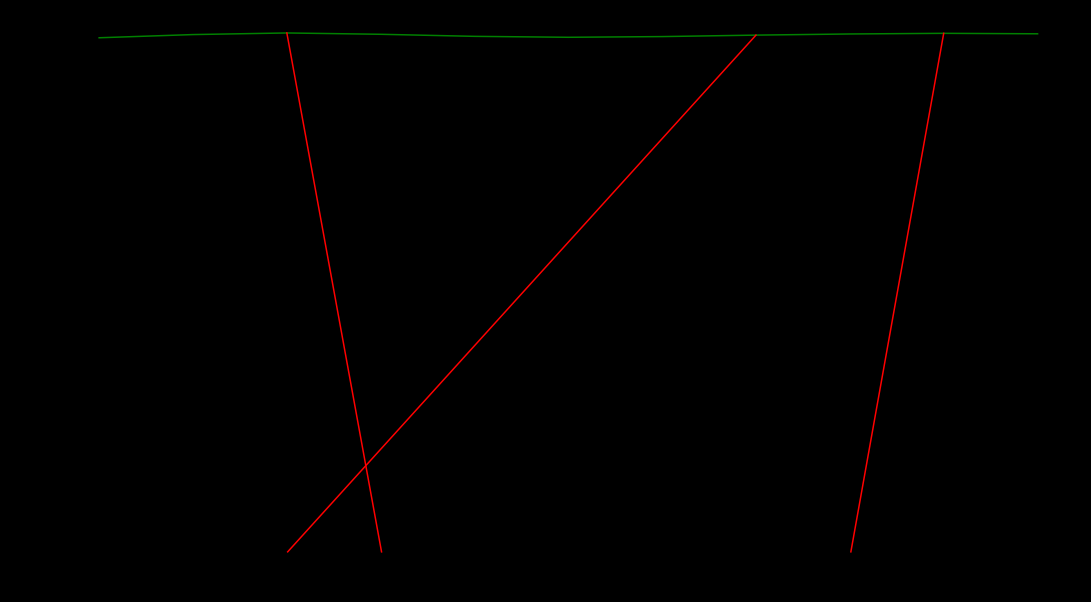

In [673]:
# plotting the best performing option from this batch of seeds

best_option = max_deformation.index(min(max_deformation))
i = best_option

def_coord = list_of_deformed[i]
nodes_el = list_of_nodes_el[i]

xtop = def_coord[:resolution+1,0]
ytop = def_coord[:resolution+1,1]

xcolumns = []
ycolumns = []

for k in range(no_columns):
  start = def_coord[ nodes_el[ k,0 ] , : ]
  end =   def_coord[ nodes_el[ k,1 ] , : ]
  xcolumns.append([start[0],end[0]])
  ycolumns.append([start[1],end[1]])

#Plotting the structre here with spacing for each iteration

plt.plot(xtop + spacing_factor * hor_spacing, ytop + spacing_factor * ver_spacing, color='g')

xcolumns = np.array(xcolumns)
ycolumns = np.array(ycolumns)
for u in range(no_columns):
  plt.plot(xcolumns[u] + spacing_factor * hor_spacing, ycolumns[u] + spacing_factor * ver_spacing, color='r')

#text label
# plt.text(spacing_factor * hor_spacing,
#           spacing_factor * ver_spacing ,
#           i, fontsize=10)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
ax = plt.gca()
ax.set_facecolor('xkcd:black')
fig.set_facecolor('xkcd:black')
plt.show()


# Plot all


Below here the script will plot all the generated versions.

### Warning
Only do this if you have generated less than 625 or so, otherwise it will take too long to plot and the text labels will be too out of scale.



In [674]:
# Safety stop, to prevent automatic plotting

1/0

# this will prevent this and the next cell from running automatically

ZeroDivisionError: ignored

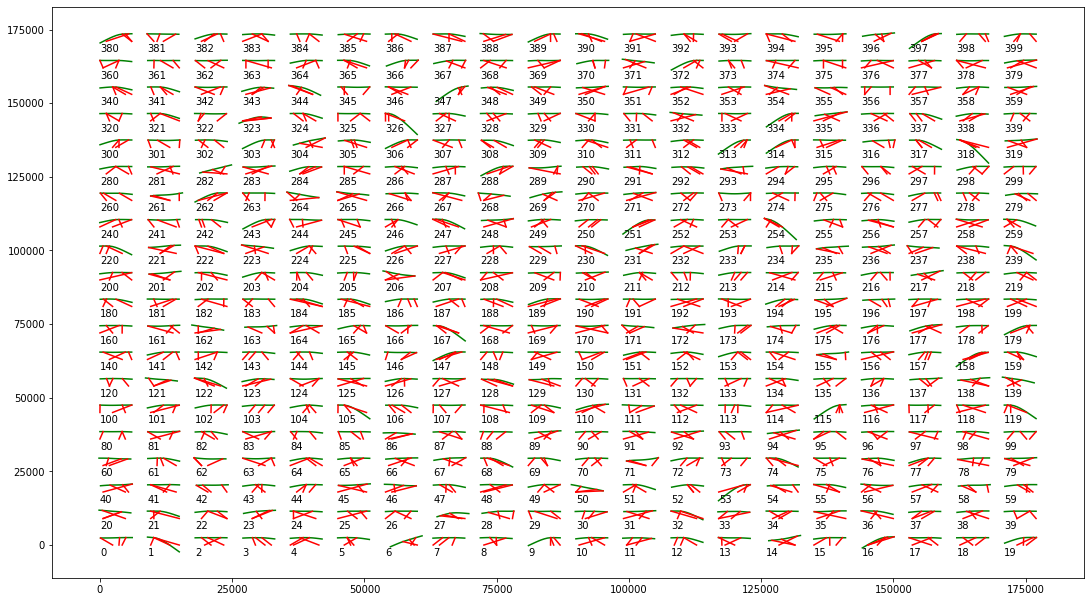

In [675]:
grid_dim = math.ceil(math.sqrt(len(list_of_deformed)))
spacing_factor = max(width,height) *1.5 # the spacing between each portal frame plot on the graph below

for hor_spacing in range(grid_dim):
  for ver_spacing in range(grid_dim):      

    i = hor_spacing + ver_spacing * grid_dim
    if i >= len(list_of_deformed):
      break

    def_coord = list_of_deformed[i]
    nodes_el = list_of_nodes_el[i]

    xtop = def_coord[:resolution+1,0]
    ytop = def_coord[:resolution+1,1]

    xcolumns = []
    ycolumns = []
    
    for k in range(no_columns):
      start = def_coord[ nodes_el[ k,0 ] , : ]
      end =   def_coord[ nodes_el[ k,1 ] , : ]
      xcolumns.append([start[0],end[0]])
      ycolumns.append([start[1],end[1]])

    #Plotting the structre here with spacing for each iteration

    plt.plot(xtop + spacing_factor * hor_spacing, ytop + spacing_factor * ver_spacing, color='g')

    xcolumns = np.array(xcolumns)
    ycolumns = np.array(ycolumns)
    for u in range(no_columns):
      plt.plot(xcolumns[u] + spacing_factor * hor_spacing, ycolumns[u] + spacing_factor * ver_spacing, color='r')
    
    #text label
    plt.text(spacing_factor * hor_spacing,
             spacing_factor * ver_spacing - spacing_factor*0.4,
             i, fontsize=10)
    


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

# Make black
# ax = plt.gca()
# ax.set_facecolor('xkcd:black')
# fig.set_facecolor('xkcd:black')

plt.show()
